In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as snc
import sklearn as sk
pd.set_option('display.max_columns', None)


## loading data

In [ ]:
df=pd.read_csv(r"/content/Churn_Modelling.csv").drop(columns=['Surname','RowNumber'])

### Splitting data into train and test

In [ ]:
from sklearn.model_selection import train_test_split
train_data,validation_data=train_test_split(df,test_size=.20,train_size=.80,random_state=2020)

In [ ]:
df.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## sepatating Features into numerical cols and catergorical cols

In [ ]:
num_cols=list(set(train_data.describe().columns.to_list())-set(['CustomerId','IsActiveMember','HasCrCard','Exited']))
cat_cols=list(set(train_data.columns.to_list())-set(num_cols)-set(['CustomerId','IsActiveMember','HasCrCard','Exited']))


visualizing numerical cols

array([[<Axes: title={'center': 'CustomerId'}>,
        <Axes: title={'center': 'CreditScore'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'Tenure'}>,
        <Axes: title={'center': 'Balance'}>,
        <Axes: title={'center': 'NumOfProducts'}>],
       [<Axes: title={'center': 'HasCrCard'}>,
        <Axes: title={'center': 'IsActiveMember'}>,
        <Axes: title={'center': 'EstimatedSalary'}>],
       [<Axes: title={'center': 'Exited'}>, <Axes: >, <Axes: >]],
      dtype=object)

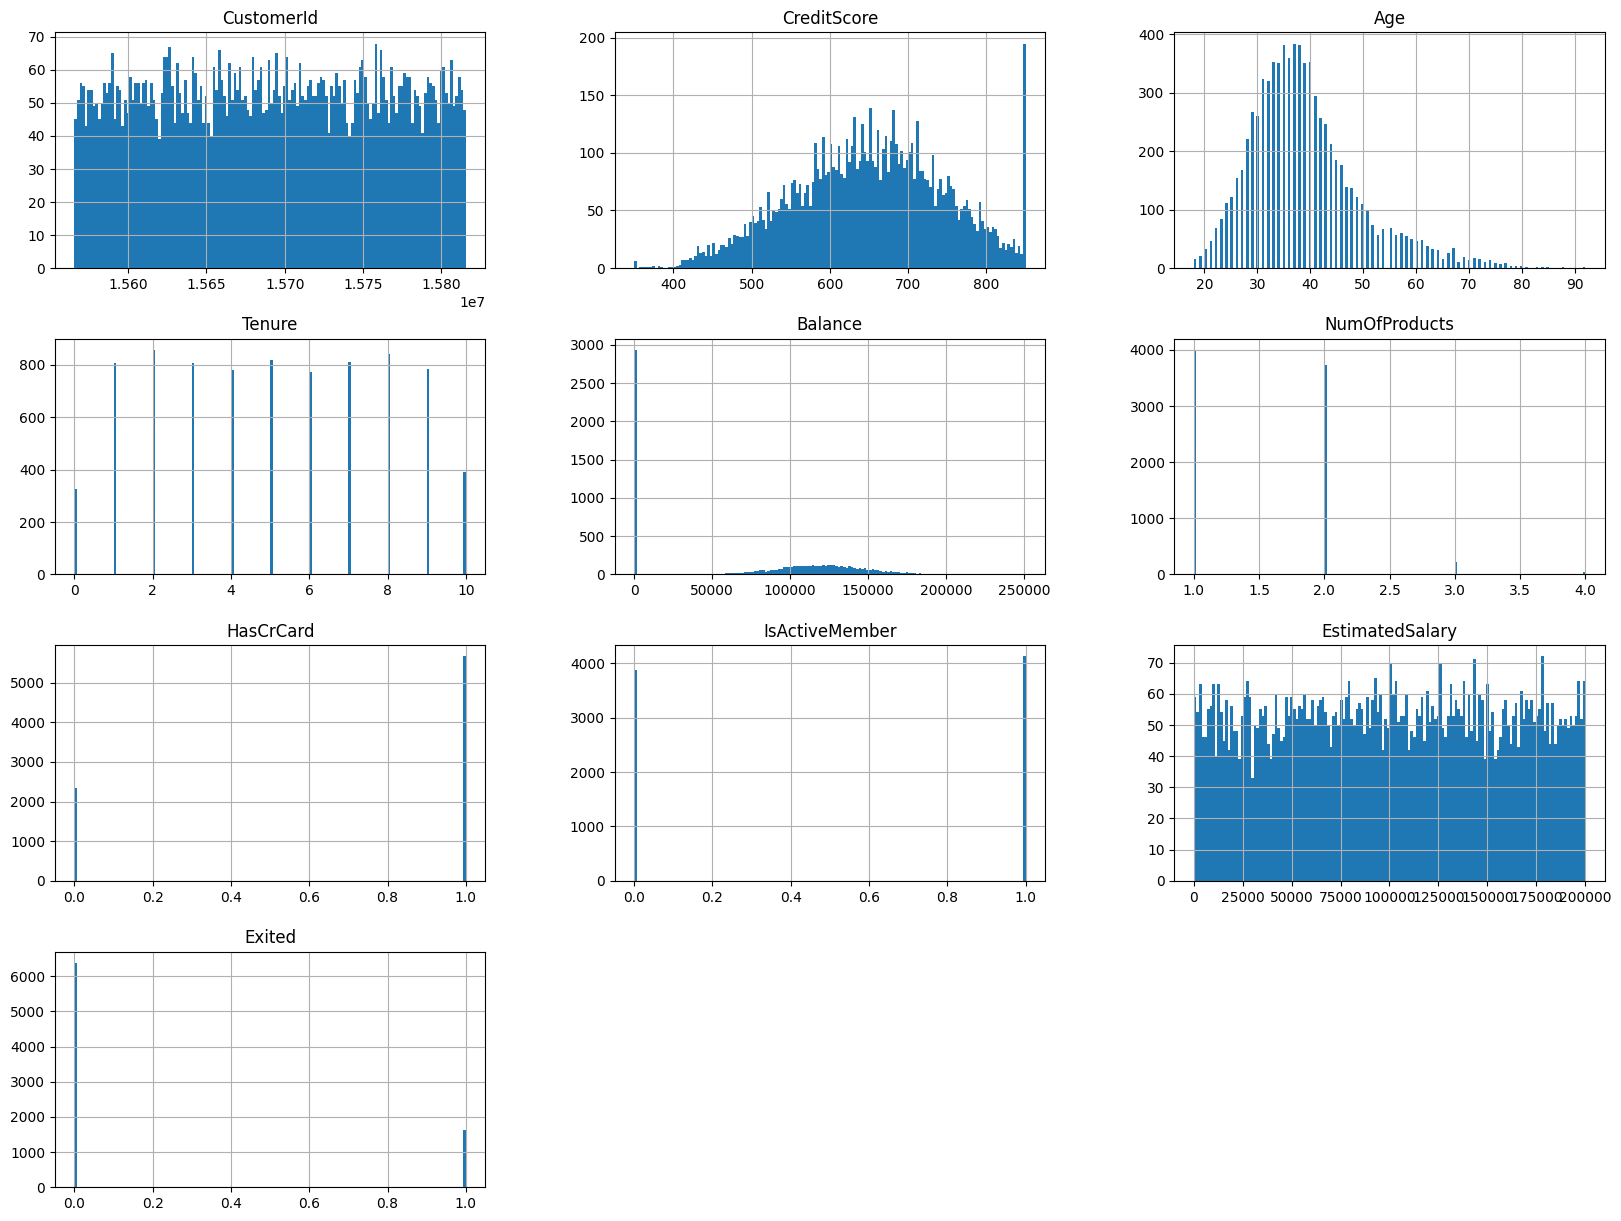

In [ ]:
%matplotlib inline
train_data.hist(bins=150,figsize=(20,15))

## Handelling nulls

In [ ]:
df.isna().sum()

,0
CustomerId,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0


In [ ]:
df_list=[]
for cat_column in cat_cols:
   df_list.append(train_data.groupby([cat_column]) ['CustomerId' ]. count(). reset_index().rename(columns = {'CustomerId' : 'count'}))

df_list

[   Gender  count
 0  Female   3635
 1    Male   4365,
   Geography  count
 0    France   4028
 1   Germany   1990
 2     Spain   1982]

checking dublicats

In [ ]:
df_list=[]
for cat_column in cat_cols:
   df_list.append(train_data.groupby([cat_column]) ['CustomerId' ]. count(). reset_index().rename(columns = {'CustomerId' : 'count'}))

def dropping_var_wth_same_value_80_time(count_df, df):
  highest_freq_percentage = (count_df['count' ]/df.count() [0]).\
  reset_index().sort_values(by = ['count'], ascending = False).iloc[0,1]
  if highest_freq_percentage >= 0.8:
     print('we will drop the column ', count_df.columns[0])
     df = df.drop(columns = [count_df.columns[0]])
  return df

df_list = []
for col in list(set(train_data.columns) - set(['CustomerId'])):
 df_list.append(train_data.groupby([col])['CustomerId'].count().reset_index().rename(columns = {'CustomerId' : 'count'}))




## Handelling Skewness and Outliers

In [ ]:
def calc_Boubdries(df,col):
  Q1=df[col].quantile(0.25)
  Q3=df[col].quantile(0.75)
  IQR=Q3-Q1
  Upper_Boundry=Q3+ 5*IQR
  Lower_Boundry=Q1- 5*IQR
  return Upper_Boundry,Lower_Boundry

  #Handelling Outliers
def Outliers_Handelling( Upper_Boundry,Lower_Boundry,value):
    if value>Upper_Boundry:
      return Upper_Boundry
    elif value<Lower_Boundry:
      return Lower_Boundry
    else:
      return value

def skewness_calc(col ,df):
    std_col = np.std(df[col])
    mean_col = np.mean(df[col])
    size_rows = df.count().iloc[0]
    df['diff_col'] = df[col] - mean_col
    df['diff_col_powered' ] = np.power(df['diff_col'], 3)
    skewness = np.sum(df['diff_col_powered'])/((size_rows -1) * np.power(std_col, 3))
    df = df.drop(columns = ['diff_col_powered', 'diff_col']) # Removing cols used in calculations
    return skewness

def skewed_data_transformation(value):
   return np.log(1 + np.abs(value))



## Outlier Handilling

In [ ]:
for col in num_cols:
  Upper_Boundry,Lower_Boundry=calc_Boubdries(train_data,col)
  validation_data[col]=validation_data[col].apply(lambda x:Outliers_Handelling(Upper_Boundry,Lower_Boundry,x))
  train_data[col]=train_data[col].apply(lambda x:Outliers_Handelling(Upper_Boundry,Lower_Boundry,x))

## Skewness Handelling

In [ ]:
for col in num_cols:
  skewed_cols=[]
  skewness=skewness_calc(col,df)
  if np.abs(skewness)>=1:
    skewed_cols.append(col)
    train_data[col]=train_data[col].apply(lambda x:skewed_data_transformation(x))
    validation_data[col]=validation_data[col].apply(lambda x:skewed_data_transformation(x))


In [ ]:
train_data.columns

Index(['CustomerId', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

## Standrization and Min_Max Scaling

### 1-Spliting Features with Saphero Welk Test
a-Feature fitted with MIn_max Scaling.              
b- Feature fitted with Standerd scaling (with Normal distripution).


In [ ]:
features_with_min_max=[]
features_with_Standerd=[]

sample_data=train_data.sample(replace=False,n=500)

from scipy.stats import shapiro

for col in num_cols:
  statistic,p_value=shapiro(sample_data[col])
  alpha=.001
  if p_value>alpha:
    features_with_Standerd.append(col)
  else:
    features_with_min_max.append(col)



In [ ]:
print("features_with_min_max :",features_with_min_max)
print("features_with_Standerd :",features_with_Standerd)

features_with_min_max : ['EstimatedSalary', 'Tenure', 'NumOfProducts', 'Balance']
features_with_Standerd : ['Age', 'CreditScore']


In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
Min_Max_Scaler=MinMaxScaler()
std_scaler=StandardScaler()

## putting them into Variable to use these scalers to transform test or validation data
MinMAx_Scaler_model=Min_Max_Scaler.fit(train_data[features_with_min_max])
Std_Scaler_model=std_scaler.fit(train_data[features_with_Standerd])

## Transforming MIN_MAX scaler features
MinMAx_Scaler_train_data = pd.DataFrame(MinMAx_Scaler_model.transform(train_data[features_with_min_max]),columns=features_with_min_max)
MinMAx_Scaler_validation_data = pd.DataFrame(MinMAx_Scaler_model.transform(validation_data[features_with_min_max]),columns=features_with_min_max)

## Transforming Standered Scaler feature
std_scaler_train_data=pd.DataFrame(Std_Scaler_model.transform(train_data[features_with_Standerd]),columns=features_with_Standerd)
std_scaler_validation_data=pd.DataFrame(Std_Scaler_model.transform(validation_data[features_with_Standerd]),columns=features_with_Standerd)

## Working on catigorical Data

#### Label Encoding


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
label_encoding_model=LabelEncoder().fit(train_data['Gender'])
train_data['Gender']=label_encoding_model.transform(train_data['Gender'])
validation_data['Gender']=label_encoding_model.transform(validation_data['Gender'])

one_hot_enc_model = OneHotEncoder(sparse_output=False).fit(train_data[['Geography']])
ohe_train_data = one_hot_enc_model.transform(train_data[['Geography']])
ohe_validation_data = one_hot_enc_model.transform(validation_data[['Geography']])

a=one_hot_enc_model.categories_
col_names=[]
for list_ in a:
    for element in list_:
        col_names.append(element)
nominal_train_df = pd.DataFrame(ohe_train_data,columns=col_names)
nominal_validation_data = pd.DataFrame(ohe_validation_data,columns=col_names)

In [ ]:
num_train_df = std_scaler_train_data.merge(MinMAx_Scaler_train_data, right_index = True, left_index = True) \
.merge(train_data[ ['HasCrCard', 'Exited', 'IsActiveMember' ]], right_index = True, left_index = True)

num_test_df = std_scaler_validation_data.merge(MinMAx_Scaler_validation_data, right_index = True, left_index = True) \
.merge(validation_data[['HasCrCard', 'Exited', 'IsActiveMember' ]], right_index = True, left_index = True)

In [ ]:
num_train_df

,Age,CreditScore,EstimatedSalary,Tenure,NumOfProducts,Balance,HasCrCard,Exited,IsActiveMember
0,0.515614,0.893111,0.199247,0.0,0.000000,0.319217,1,1,1
2,0.234172,0.491365,0.538889,0.7,0.666667,0.418743,1,1,0
3,-0.068665,-0.919897,0.415219,0.5,0.333333,0.000000,0,0,0
4,0.944569,-0.281224,0.594116,0.1,0.000000,0.430758,1,0,1
5,0.692773,-1.568871,0.829907,0.7,0.333333,0.435239,1,1,0
...,...,...,...,...,...,...,...,...,...
7994,-1.010777,0.800401,0.415033,0.1,0.000000,0.000000,1,1,1
7995,-0.284146,1.068231,0.530393,0.6,0.333333,0.392932,0,0,1
7996,-0.630925,0.408956,0.689469,0.0,0.333333,0.425207,1,0,1
7997,1.181397,-0.075200,0.174474,0.2,0.000000,0.419411,1,0,0


In [ ]:
final_train_data = nominal_train_df.merge(train_data['Gender'], right_index = True, left_index = True, how = 'inner' )

final_validation_data = nominal_validation_data.merge(validation_data['Gender'], right_index = True, left_index = True, how = 'inner')

In [ ]:
final_train_data.head()

,France,Germany,Spain,Gender
0,1.0,0.0,0.0,0
2,1.0,0.0,0.0,0
3,1.0,0.0,0.0,0
4,0.0,1.0,0.0,0
5,0.0,1.0,0.0,1


## Modelling

In [ ]:
train_x=num_train_df.drop(columns=['Exited'])
train_y=num_train_df[['Exited']]

validation_x=num_test_df.drop(columns=['Exited'])
validation_y=num_test_df[['Exited']]

# Implementing Logistic Regression from Scratch

In [ ]:
#weights =Theta
def initalize(X, bias=True):
  if bias:
    # Changed the second argument to np.int64
    weights = np.zeros((X.shape[1] + 1, 1), dtype=np.int64)
    X = np.c_[np.ones((X.shape[0], 1), dtype=np.int64), X]
  else:
    weights = np.zeros((X.shape[1], 1), dtype=np.int64)

  return weights, X

def sigmoid(z): # z= dot product brtwen weights and X
    seg=1 / (1+(np.e **(-z)))
    return seg



Defining Gradient Decient

In [ ]:

def GD_Fit(X,Y,lr=.001,bias=True,max_itiration=100):
  weights,X=initalize(X,bias)
  Y_np = Y.to_numpy()

  for i in range(max_itiration):

    weights=weights-lr * np.dot(X.T,sigmoid(np.dot(X,weights))-Y_np.reshape(-1, 1))
  return weights ## == OPtimal Weights OR theta

def prodict(X,Optimal_weights,bias=True,threshold=.5):
  z=np.dot(initalize(X,bias)[1],Optimal_weights)
  pred=[]
  for pridic_proba in sigmoid(z):
    if pridic_proba >threshold:
      pred.append(1)
    else :
      pred.append(0)
  return pred


In [ ]:
Optimal_weights = GD_Fit(train_x, train_y, lr=.001, bias=True, max_itiration=100)



## Predictions

In [ ]:
test_predics=prodict(validation_x,Optimal_weights,bias=True,threshold=.5)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_predics,validation_y)


0.7995110024449877

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix=pd.DataFrame(confusion_matrix(validation_y,test_predics).T).rename(columns={0: "actual not churn",1: "actual churn"})

conf_matrix

,actual not churn,actual churn
0,327,82
1,0,0
